**Implemented by: Anika Shrivastava**

## **important imports**



In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import random
import cv2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Input, LeakyReLU, Add, Concatenate, concatenate
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import load_model
import math
import pandas as pd
#import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### **drive mounted**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **reading the images**

In [26]:
def read(path):
    path = path
    dataset = []

    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(path, filename)
            img = image.load_img(image_path,target_size=(256,256,3),color_mode= 'rgb')
            img=image.img_to_array(img)
            img=img/255
            dataset.append(img)
    dataset= np.array(dataset)
    return dataset

### **Dataset BSDS300 can be accessed from the link: https://www.kaggle.com/datasets/adheshgarg/bsds300**

In [27]:
path = '/content/drive/MyDrive/Colab Notebooks/BSDS300_all'    # change the path accrodingly
dataset = read(path)

In [28]:
dataset.shape

(300, 256, 256, 3)

In [38]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(256,256,3))
    plt.show()

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))          #20

In [39]:
train=dataset[0:220]
val=dataset[220:250]
test= dataset[250:300]

### **creating classes as described in CreateDataset.ipynb**

In [40]:
class0=test
class1=[]
for i in class0:
        # Generate Poisson noise
        noise = np.random.poisson(i)
        noisy_image = (i + noise)
        max_pixel_value = np.max(noisy_image)
        # print("Maximum Pixel Value:", max_pixel_value)
        class1.append(noisy_image)
class1= np.array(class1)

In [41]:
class2, class3, class4, class5=[], [] , [], []
output= [class2, class3, class4, class5]
variances = [0.003, 0.008, 0.01, 0.04]

for i in class0:
        # Add Gaussian noise with different variances
        for idx, variance in enumerate(variances):
            row, col, channel = i.shape
            noise = np.random.normal(0, np.sqrt(variance), (row, col, channel))
            noisy_image = i + noise
            output[idx].append(noisy_image)

class2= np.array(class2)
class3= np.array(class3)
class4= np.array(class4)
class5= np.array(class5)
print(f"Done")

Done


In [42]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2)/(2*sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def apply_gaussian_blur(image, sigma, kernel_size):
    kernel = gaussian_kernel(kernel_size, sigma)
    blurred_image = cv2.filter2D(image, -1, kernel)
    return blurred_image

class6, class7, class8, class9 = [], [], [] ,[]
output = [class6, class7, class8, class9]
sigmas = [1.5, 3, 5, 10]
kernel_sizes = [3, 5, 7, 9]

for i in class0:
    # applying Gaussian blur with corresponding sigma and kernel size
    for j, sigma in enumerate(sigmas):
        kernel_size = kernel_sizes[j]
        blurred_image = apply_gaussian_blur(i, sigma, kernel_size)
        output[j].append(blurred_image)

class6= np.array(class6)
class7= np.array(class7)
class8= np.array(class8)
class9= np.array(class9)
print("done")

done


### **creating test dataset with 10 classes**

In [43]:
test_data=[]
test = []
for i in class0:
    test_data.append(i)
    test.append(0)
for i in class1:
    test_data.append(i)
    test.append(1)
for i in class2:
    test_data.append(i)
    test.append(2)
for i in class3:
    test_data.append(i)
    test.append(3)
for i in class4:
    test_data.append(i)
    test.append(4)
for i in class5:
    test_data.append(i)
    test.append(5)
for i in class6:
    test_data.append(i)
    test.append(6)
for i in class7:
    test_data.append(i)
    test.append(7)
for i in class8:
    test_data.append(i)
    test.append(8)
for i in class9:
    test_data.append(i)
    test.append(9)
# for i in class10:
#     test_data.append(i)
#     test.append(10)
test_data= np.array(test_data)
print(np.shape(test_data))
test_out = np.array(list(map(int, test)))
print(np.shape(test_out))

(500, 256, 256, 3)
(500,)


## **Experiment-1 (Training an autoencoder model to reconstruct the original image back)**

### **Architecture 0: autoencoder model without skip connections**

In [44]:
# Input layer for 256x256x3 images
input_img = Input(shape=(256, 256, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
encoded= MaxPooling2D((2,2), padding='same')(x)

# at this point the representation is (32, 32, 128)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [ ]:
history= autoencoder.fit(train, train, epochs=10, batch_size=12, validation_data=(val, val))

Epoch 1/10
19/19 [==============================] - 112s 6s/step - loss: 0.0594 - val_loss: 0.0399
Epoch 2/10
19/19 [==============================] - 109s 6s/step - loss: 0.0333 - val_loss: 0.0186
Epoch 3/10
19/19 [==============================] - 100s 5s/step - loss: 0.0199 - val_loss: 0.0134
Epoch 4/10
19/19 [==============================] - 96s 5s/step - loss: 0.0146 - val_loss: 0.0115
Epoch 5/10
19/19 [==============================] - 95s 5s/step - loss: 0.0124 - val_loss: 0.0108
Epoch 6/10
19/19 [==============================] - 99s 5s/step - loss: 0.0115 - val_loss: 0.0096
Epoch 7/10
19/19 [==============================] - 102s 5s/step - loss: 0.0107 - val_loss: 0.0088
Epoch 8/10
19/19 [==============================] - 96s 5s/step - loss: 0.0101 - val_loss: 0.0081
Epoch 9/10
19/19 [==============================] - 100s 5s/step - loss: 0.0093 - val_loss: 0.0076
Epoch 10/10
19/19 [==============================] - 97s 5s/step - loss: 0.0090 - val_loss: 0.0075


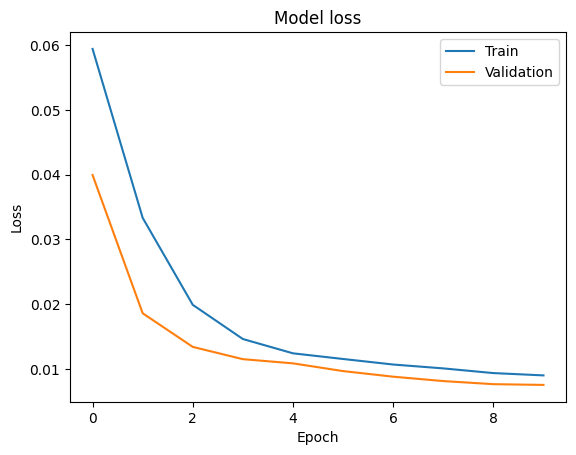

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/model_loss_project1')

### **weights for the model is uploaded in repo as arch0.h5**

In [45]:
autoencoder.load_weights('/content/drive/MyDrive/Colab Notebooks/trying_weights2.h5')    #change path accrodingly

### **checking recons on train data**

In [46]:
train_pred = autoencoder.predict(train)

7/7 [==============================] - 28s 4s/step


In [51]:
psnr(train[70],train_pred[70])

24.61916854875552

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed image (PSNR:24.619)')

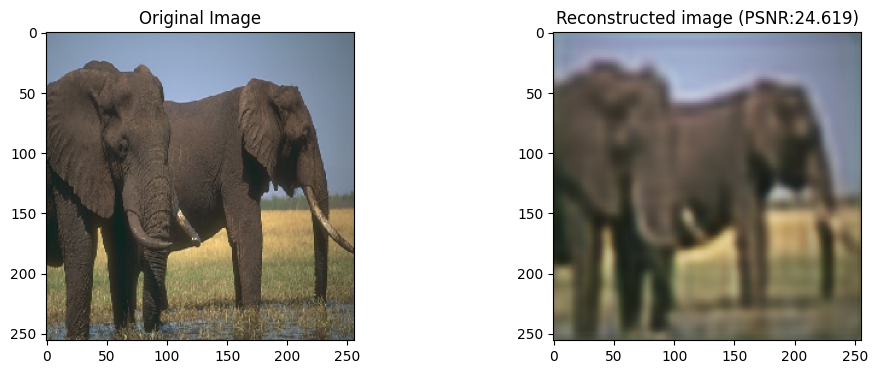

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
print("original shape", np.shape(train[70]))
ax[0].imshow(train[70])
ax[0].set_title("Original Image")

ax[1].imshow(train_pred[70])
ax[1].set_title("Reconstructed image (PSNR:24.619)")

In [53]:
psnr(train[37],train_pred[37])

23.537287532551396

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed image (PSNR:23.537)')

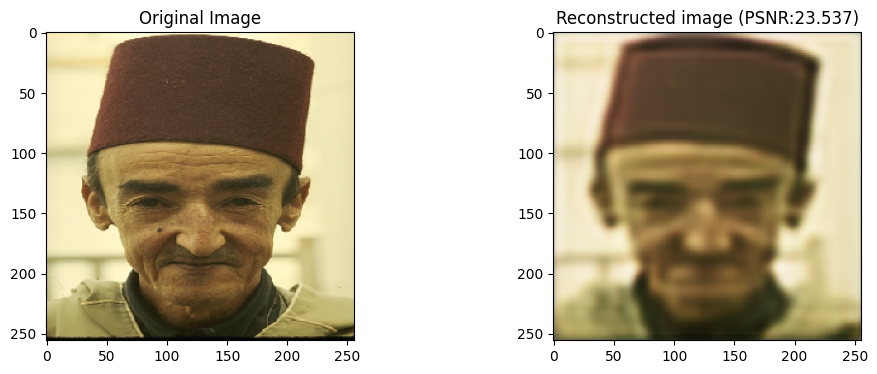

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
print("original shape", np.shape(train[37]))
ax[0].imshow(train[37])
ax[0].set_title("Original Image")

ax[1].imshow(train_pred[37])
ax[1].set_title("Reconstructed image (PSNR:23.537)")

### **Checking reconstruction error on test dataset**

In [ ]:
# Evaluate the model on the test set
test_loss1 = autoencoder.evaluate(test_data, test_data)
print('Average reconstruction error:', test_loss1)

16/16 [==============================] - 54s 3s/step - loss: 0.0671
Average reconstruction error: 0.06707758456468582


In [55]:
test_predict = autoencoder.predict(test_data)

16/16 [==============================] - 64s 4s/step


original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed test image')

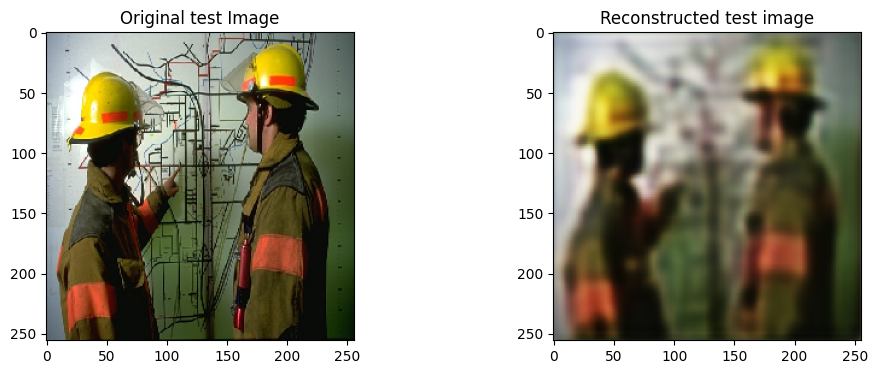

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
print("original shape", np.shape(test_data[30]))
ax[0].imshow(test_data[30])
ax[0].set_title("Original test Image")

ax[1].imshow(test_predict[30])
ax[1].set_title("Reconstructed test image")

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed image')

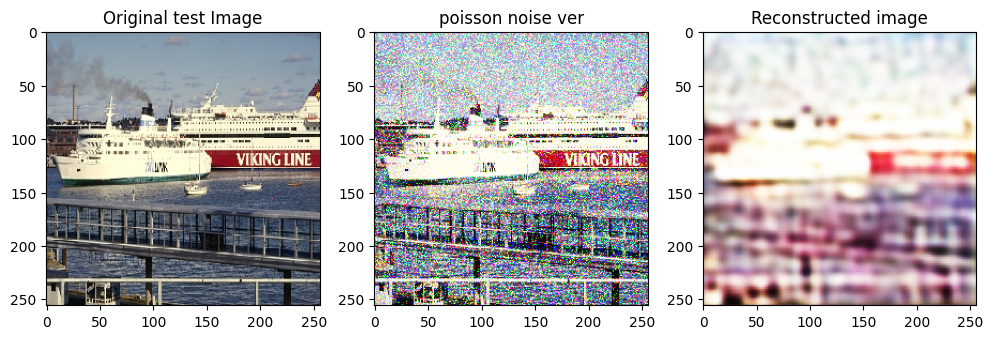

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
print("original shape", np.shape(test_data[31]))
ax[0].imshow(test_data[31])
ax[0].set_title("Original test Image")

ax[1].imshow(class1[31])
ax[1].set_title("poisson noise ver")

ax[2].imshow(test_predict[81])
ax[2].set_title("Reconstructed image")

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed image')

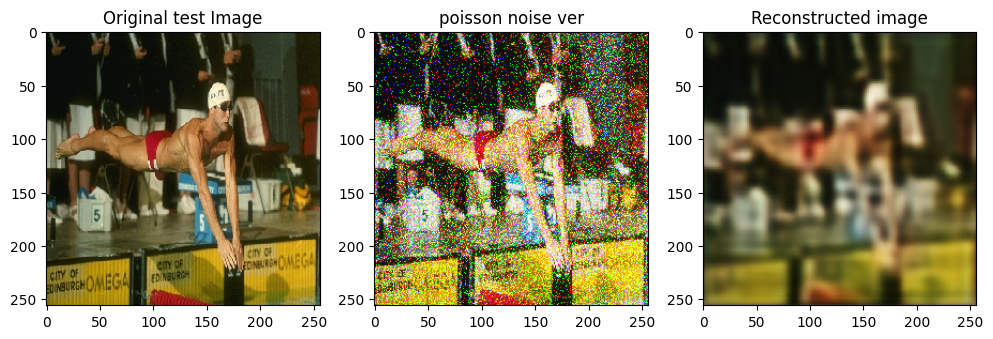

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
print("original shape", np.shape(test_data[8]))
ax[0].imshow(test_data[8])
ax[0].set_title("Original test Image")

ax[1].imshow(class1[8])
ax[1].set_title("poisson noise ver")

ax[2].imshow(test_predict[8])
ax[2].set_title("Reconstructed image")

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed test image')

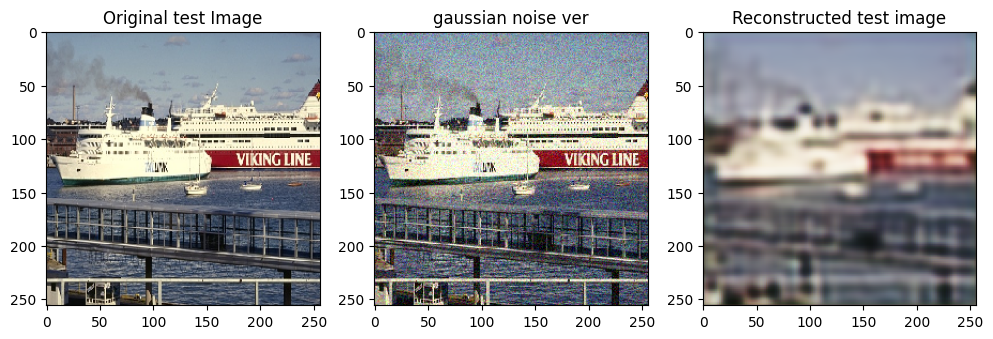

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
print("original shape", np.shape(test_data[31]))
ax[0].imshow(test_data[31])
ax[0].set_title("Original test Image")

ax[1].imshow(class3[31])
ax[1].set_title("gaussian noise ver")

ax[2].imshow(test_predict[31])
ax[2].set_title("Reconstructed test image")

original shape (256, 256, 3)


Text(0.5, 1.0, 'Reconstructed test image')

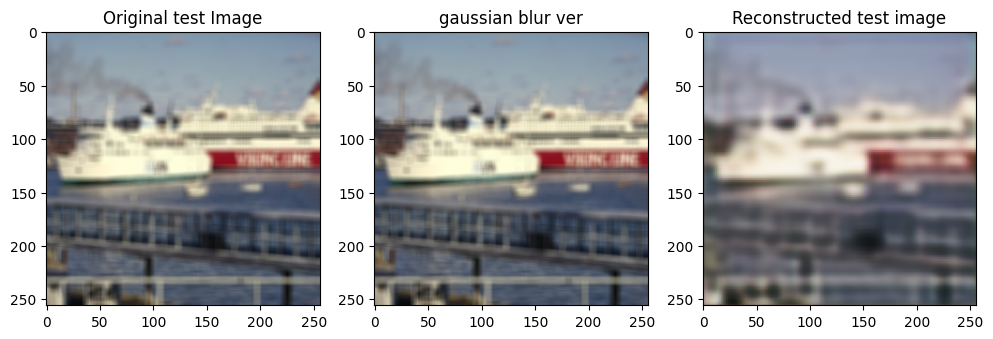

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
print("original shape", np.shape(test_data[431]))
ax[0].imshow(test_data[431])
ax[0].set_title("Original test Image")

ax[1].imshow(class8[31])
ax[1].set_title("gaussian blur ver")

ax[2].imshow(test_predict[431])
ax[2].set_title("Reconstructed test image")

## **Experiment-2 (Extracting encoded vectors to plot t-SNE of encoded vectors of test data vectors)**

In [ ]:
compressed_model = Model(inputs=input_img, outputs=encoded)

In [ ]:
#after loading weights
compressed_test_data = compressed_model.predict(test_data)

18/18 [==============================] - 25s 1s/step


In [ ]:
encoded_vec = Flatten()(compressed_test_data)
print("encoded test data vectors extracted")
# encoded_vec=np.array(encoded_vec)
# encoded_vec.shape

encoded test data vectors extracted


after flattening out encoded vector shape will be 32x32x128=131072 as per bottleneck size

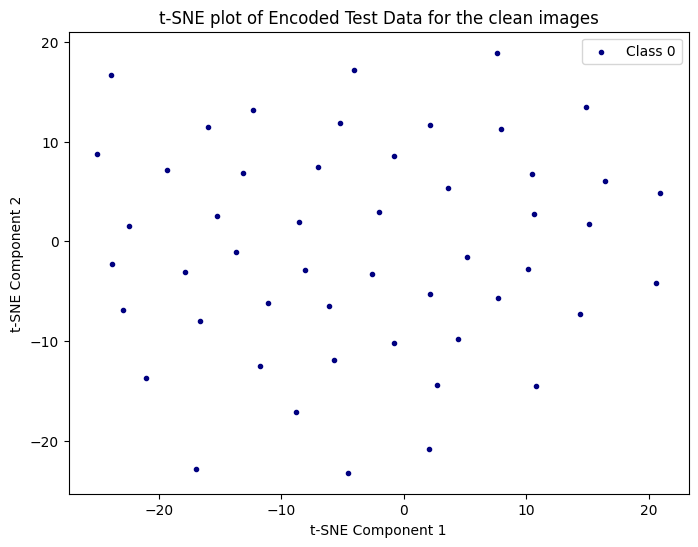

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# shape of encoded_vec is (500,131072)
data = encoded_vec
class_labels = test_out

# Applying t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Defining colors for each class
num_classes = len(np.unique(class_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

plt.figure(figsize=(8, 6))
for i in range(1):
    indices = class_labels == i
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], marker='.', color=colors[i], label=f'Class {i}')

plt.title('t-SNE plot of Encoded Test Data for the clean images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

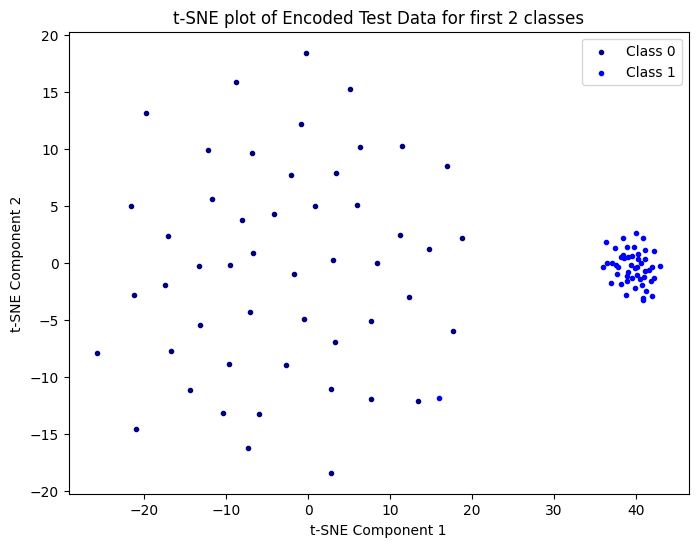

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# shape of encoded_vec is (500,131072)
data = encoded_vec
class_labels = test_out

# Applying t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Defining colors for each class
num_classes = len(np.unique(class_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

plt.figure(figsize=(8, 6))
for i in range(2):
    indices = class_labels == i
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], marker='.', color=colors[i], label=f'Class {i}')

plt.title('t-SNE plot of Encoded Test Data for first 2 classes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

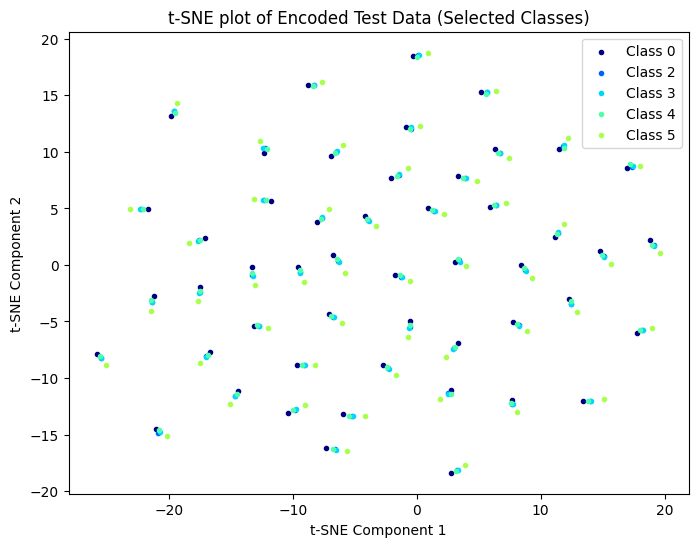

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# shape of encoded_vec is (500,131072)
data = encoded_vec
class_labels = test_out

# Specifying the classes to plot
classes_to_plot = [0, 2, 3, 4, 5]

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Defining colors for each class
num_classes = len(np.unique(class_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

plt.figure(figsize=(8, 6))
for i in classes_to_plot:
    indices = class_labels == i
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], marker='.', color=colors[i], label=f'Class {i}')

plt.title('t-SNE plot of Encoded Test Data (Selected Classes)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

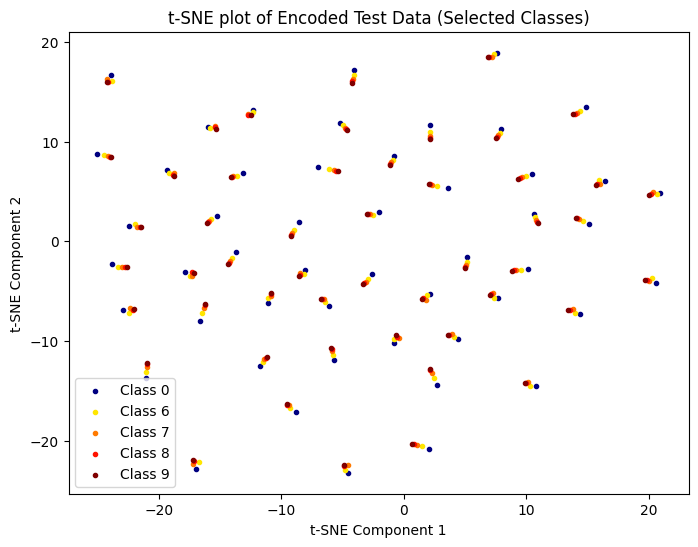

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# shape of encoded_vec is (500,131072)
data = encoded_vec
class_labels = test_out

# Specifying the classes to plot
classes_to_plot = [0, 6, 7, 8, 9]

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Defining colors for each class
num_classes = len(np.unique(class_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

plt.figure(figsize=(8, 6))
for i in classes_to_plot:
    indices = class_labels == i
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], marker='.', color=colors[i], label=f'Class {i}')

plt.title('t-SNE plot of Encoded Test Data (Selected Classes)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

### **Final t-SNE of all classes of encoded test vectors**

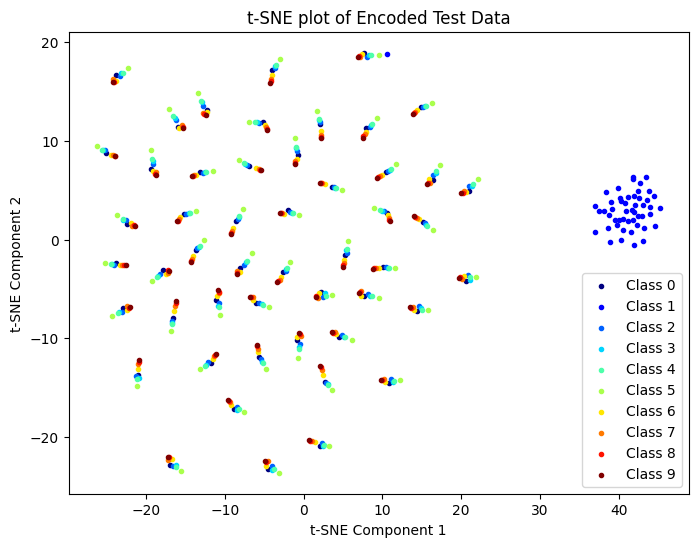

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# shape of encoded_vec is (500,131072)
data = encoded_vec
class_labels = test_out

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Defining colors for each class
num_classes = len(np.unique(class_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    indices = class_labels == i
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], marker='.', color=colors[i], label=f'Class {i}')

plt.title('t-SNE plot of Encoded Test Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()